#  Прогнозирование заказов такси

<a id='section_id'></a>
## Содержание 

[Шаг 1. Загрузка данных](#section_id1)

[Шаг 2. Предобработка и исследовательский анализ](#section_id2)

[Шаг 3. Подготовка данных](#section_id3)

[Шаг 4. Обучение моделей](#section_id4)

[Шаг 5. Проверка на тестовой выборке](#section_id5)

[Шаг 6. Вывод](#section_id6)

## Описание исследования

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Цель исследования

- Создать регрессионную модель для прогнозирования значений временного ряда

## Ход исследования

1. Загрузка данных
2. Предобработка и исследовательский анализ
3. Подготовка данных
4. Обучение моделей
5. Проверка на тестовой выборке
6. Вывод

## Описание данных

- 'datetime' содержит дату и время заказа
- 'num_orders' содержит количество заказов

In [1]:
# импорт библиотек

# работа с данными
import pandas as pd
import numpy as np

# графика
import matplotlib.pyplot as plt
import seaborn as sns

# анализ временных рядов
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

# подготовка данных
from sklearn.model_selection import train_test_split, TimeSeriesSplit

# модели машинного обучения
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

# пайплайны
from sklearn.pipeline import Pipeline

# инструменты поиска
from sklearn.model_selection import GridSearchCV

# инструменты управления ресурсами
import joblib

# метрика для оценки прогноза
from sklearn.metrics import mean_squared_error

In [2]:
# константы
TEST_SIZE = 0.25 
RANDOM_STATE = 42

<a id='section_id1'></a>
## Шаг 1. Загрузка данных
[к содержанию](#section_id)

In [3]:
# загрузка данных
df = pd.read_csv('/datasets/taxi.csv',
                 parse_dates=['datetime'],
                 index_col='datetime')
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
# сортировка по индексу
df.sort_index(inplace=True)

# ресэмплирование данных по 1 часу
df = df.resample('1H').sum()

In [5]:
# проверка атрибута freq, без которого не работает seasonal_decompose
df.index.freq

<Hour>

### Обзор данных

In [6]:
# функция для обзора данных
def preview(dataset):
    '''Функция принимает на вход набор данных и выводит основную информацию о нем.'''
    display(dataset.head())
    dataset.info()
    display(dataset.describe(include='all', datetime_is_numeric=True).T)

In [7]:
# обзор данных
preview(df)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


<a id='section_id2'></a>
## Шаг 2. Предобработка и исследовательский анализ
[к содержанию](#section_id)

### Проверка пропусков

In [8]:
# проверка на наличие пропусков
df.isna().sum()

num_orders    0
dtype: int64

### Исследовательский анализ

In [9]:
# проверка, что все данные идут в порядке увеличения даты
df.index.is_monotonic

True

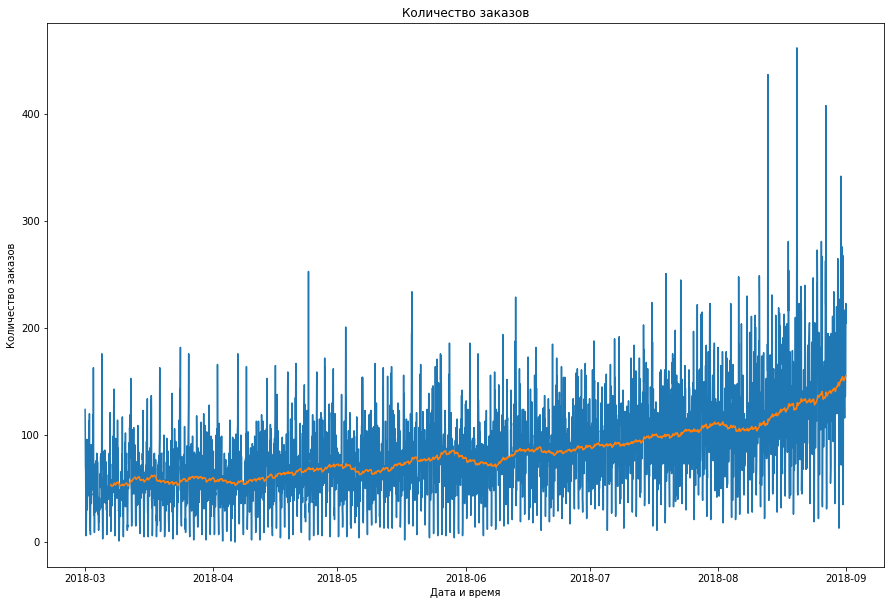

In [10]:
# расчёт скользящей средней
rolling = df.rolling(150).mean() 

# построение графика временного ряда
fig = plt.figure(figsize=(15, 10))
sns.lineplot(data=df, x=df.index, y='num_orders')
sns.lineplot(data=rolling, x=df.index, y='num_orders')
plt.title('Количество заказов')
plt.xlabel('Дата и время')
plt.ylabel('Количество заказов')
plt.show()

- Судя по графику есть восходящий тренд в плане количества заказов с течением времени
- Примерно раз в месяц наблюдаются пиковые значения количества заказов

In [11]:
# разложение временного ряда с предположением, что период сезонных колебаний равен 1 неделе
decomposed = seasonal_decompose(df)

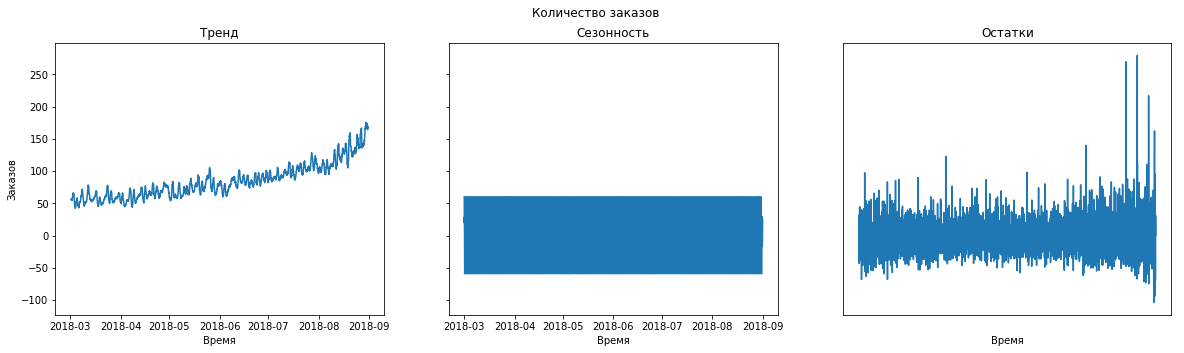

In [12]:
# построение графиков сезонной декомпозиции
fig, ax = plt.subplots(ncols=3, figsize=(20, 5), sharex=True, sharey=True)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.suptitle('Количество заказов')

sns.lineplot(data=decomposed.trend, ax=ax[0])
ax[0].set_title('Тренд')
ax[0].set_ylabel('Заказов')
ax[0].set_xlabel('Время')

sns.lineplot(data=decomposed.seasonal, ax=ax[1])
ax[1].set_title('Сезонность')
ax[1].set_ylabel('Заказов')
ax[1].set_xlabel('Время')

sns.lineplot(data=decomposed.resid, ax=ax[2])
ax[2].set_title('Остатки')
ax[2].set_ylabel('Заказов')
ax[2].set_xlabel('Время')

plt.show()

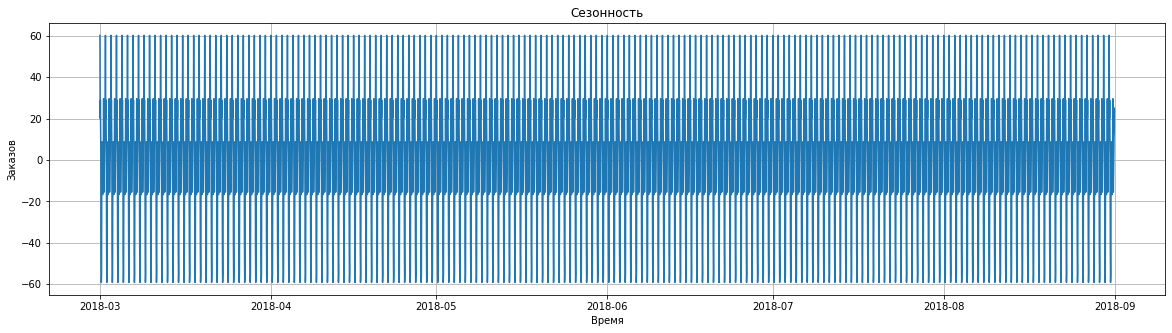

In [13]:
# рассмотрим сезонность в другом масштабе
plt.figure(figsize=(20, 5))
sns.lineplot(data=decomposed.seasonal)
plt.grid()
plt.title('Сезонность')
plt.ylabel('Заказов')
plt.xlabel('Время')
plt.show()

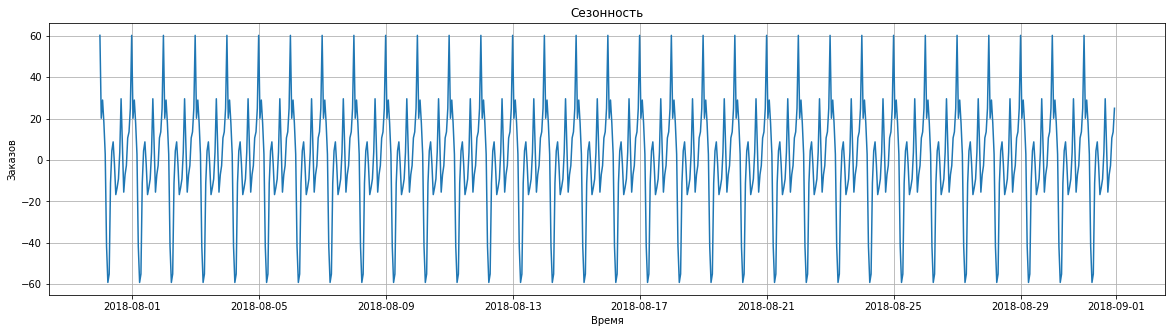

In [14]:
# рассмотрим временной промежуток
plt.figure(figsize=(20, 5))
sns.lineplot(data=decomposed.seasonal['2018-07-31':'2018-08-31'])
plt.grid()
plt.title('Сезонность')
plt.ylabel('Заказов')
plt.xlabel('Время')
plt.show()

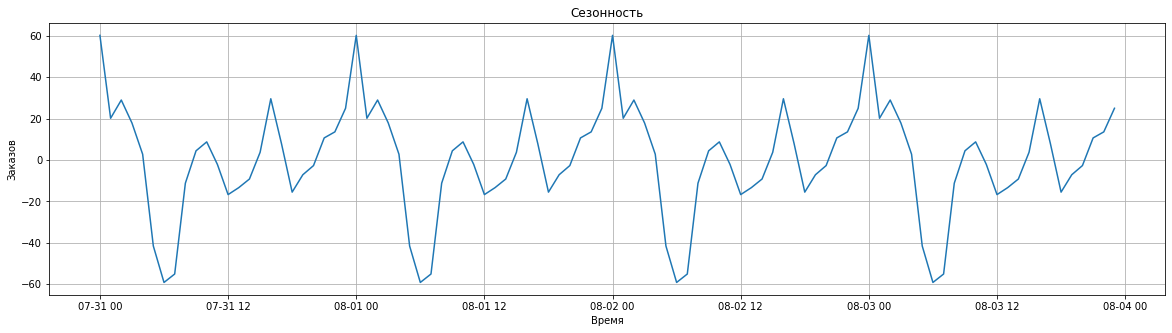

In [15]:
# рассмотрим временной промежутов
plt.figure(figsize=(20, 5))
sns.lineplot(data=decomposed.seasonal['2018-07-31':'2018-08-03'])
plt.grid()
plt.title('Сезонность')
plt.ylabel('Заказов')
plt.xlabel('Время')
plt.show()

- виден восходяший тренд
- присутствует сезонность в течение одного дня
- остатки распределены случайным образом

Примем уровень статистической значимости 0.05

Проверим гипотезу

H0: Ряд нестационарен

In [16]:
# уровень статистической значимости
alpha = 0.05

# проверка гипотезы о стационарности ряда
adf_test = adfuller(df['num_orders'])

# p-value
print('p-value = ' + str(adf_test[1]))

# проверка гипотезы
if adf_test[1] <= alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем опровергнуть нулевую гипотезу')

p-value = 0.028940051402612906
Отвергаем нулевую гипотезу


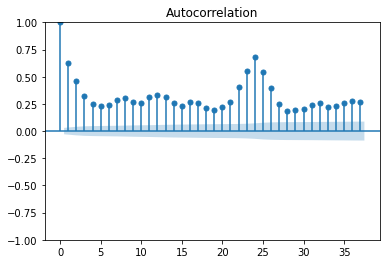

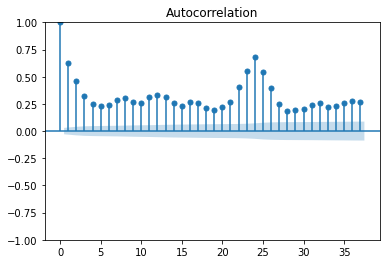

In [17]:
# анализ автокорреляции
plot_acf(df)

- заметна автокорреляция между 1 и 24 лагом, т.е. сезонность временного ряда - 24 часа

<a id='section_id3'></a>
## Шаг 3. Подготовка данных
[к содержанию](#section_id)

In [18]:
# функция для создания дополнительных признаков
def make_features(dataframe, max_lag, rolling_mean_size):
    '''Функция принимает на вход набор данных, максимальную величину лага для признаков отставания,
    размер группировки для скользящей средней'''
    data = dataframe.copy()
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

In [19]:
# создание набора данных с дополнительными признаками
data = make_features(df, 24, 150)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 29 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   month         4416 non-null   int64  
 2   day           4416 non-null   int64  
 3   dayofweek     4416 non-null   int64  
 4   lag_1         4415 non-null   float64
 5   lag_2         4414 non-null   float64
 6   lag_3         4413 non-null   float64
 7   lag_4         4412 non-null   float64
 8   lag_5         4411 non-null   float64
 9   lag_6         4410 non-null   float64
 10  lag_7         4409 non-null   float64
 11  lag_8         4408 non-null   float64
 12  lag_9         4407 non-null   float64
 13  lag_10        4406 non-null   float64
 14  lag_11        4405 non-null   float64
 15  lag_12        4404 non-null   float64
 16  lag_13        4403 non-null   float64
 17  lag_14        4402 non-null

In [20]:
# создание тренировочной и тестовой выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()


X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

<a id='section_id4'></a>
## Шаг 4. Обучение моделей
[к содержанию](#section_id)

In [21]:
# создание пайплайна
pipe_final = Pipeline([
    ('models', LinearRegression())
])

In [22]:
# задание параметров для пайплайна
param_grid = [
    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()]
    },
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_features': range(3, 5),
        'models__min_samples_leaf': range(2, 4),
        'models__max_depth': range(2, 4)
    },
    # словарь для модели LightGBM()
    {
        'models': [LGBMRegressor(n_jobs=-1)],
        'models__max_depth': [3, 4],
        'models__learning_rate': [0.1, 10.0]
    }
]

In [23]:
# инициализация подбора параметров
grid_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=TimeSeriesSplit(),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

In [24]:
%%time
# запуск подбора параметров
with joblib.parallel_backend("threading"):
    grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)

Fitting 5 folds for each of 13 candidates, totalling 65 fits
Лучшая модель и её параметры:

 Pipeline(steps=[('models', LGBMRegressor(max_depth=4))])
Метрика лучшей модели на тренировочной выборке: -25.75360589373331
CPU times: user 8min 34s, sys: 2.05 s, total: 8min 36s
Wall time: 8min 37s


In [25]:
# получение результатов лучших моделей
results = pd.DataFrame(grid_search.cv_results_)
results.sort_values(by='rank_test_score', inplace=True)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__max_depth,param_models__max_features,param_models__min_samples_leaf,param_models__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,20.402085,16.396401,0.137013,0.043741,LGBMRegressor(max_depth=4),4,NaN,NaN,0.1,"{'models': LGBMRegressor(max_depth=4), 'models...",-22.841146,-22.719548,-23.575226,-26.571375,-33.060735,-25.753606,3.911423,1
9,72.548894,53.446223,0.151876,0.048160,LGBMRegressor(max_depth=4),3,NaN,NaN,0.1,"{'models': LGBMRegressor(max_depth=4), 'models...",-22.468555,-22.828933,-23.577404,-26.749112,-34.123150,-25.949431,4.357286,2
0,0.030196,0.033256,0.100264,0.026158,LinearRegression(),NaN,NaN,NaN,NaN,{'models': LinearRegression()},-24.926069,-25.321090,-24.848959,-27.524302,-34.181157,-27.360315,3.548004,3
1,0.007392,0.002777,0.004661,0.004954,DecisionTreeRegressor(random_state=42),2,3,2,NaN,{'models': DecisionTreeRegressor(random_state=...,-27.795720,-31.061512,-30.120665,-36.493960,-44.648425,-34.024056,6.029642,4
2,0.003412,0.000414,0.001509,0.000036,DecisionTreeRegressor(random_state=42),2,3,3,NaN,{'models': DecisionTreeRegressor(random_state=...,-27.795720,-31.061512,-30.120665,-36.493960,-44.648425,-34.024056,6.029642,4


<a id='section_id5'></a>
## Шаг 5. Проверка на тестовой выборке
[к содержанию](#section_id)

In [26]:
# проверка лучшей модели на тестовой выборке
pred = grid_search.best_estimator_.predict(X_test)

print("RMSE тестовой выборки:", mean_squared_error(y_test, pred, squared=False))

RMSE тестовой выборки: 43.26898121661633


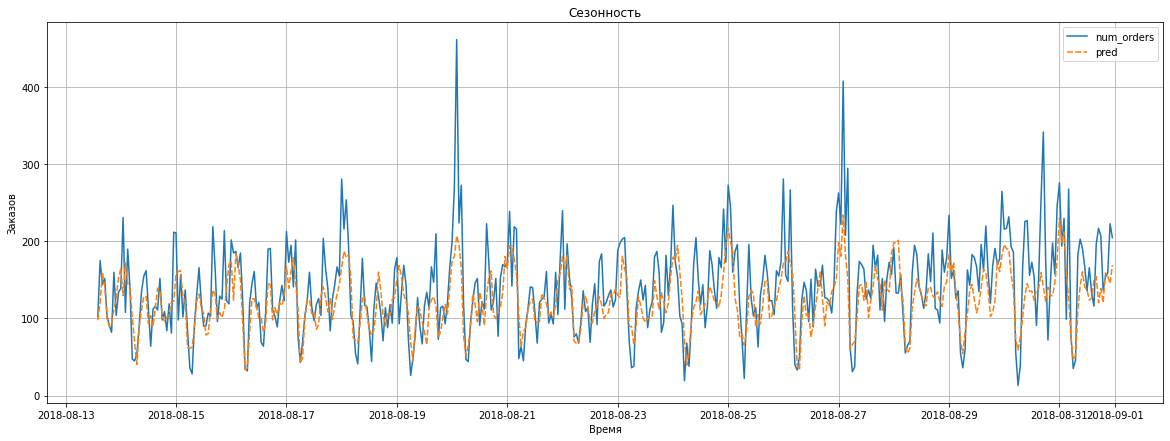

In [27]:
# построение графика для оценки прогноза
res = pd.concat([y_test, pd.Series(pred, index=y_test.index, name='pred')], axis=1)

plt.figure(figsize=(20, 7))
sns.lineplot(data=res)
plt.grid()
plt.title('Сезонность')
plt.ylabel('Заказов')
plt.xlabel('Время')
plt.show()

<a id='section_id6'></a>
## Шаг 6. Вывод
[к содержанию](#section_id)

Проведен анализ данных временного ряда заказов такси. Обнаружен восходящий тренд, обнаружена сезонность с периодом в 1 день.
Данные были обогащены путем создания дополнительных признаков (лаги, скользящая средняя, данные, полученные из даты).
Для обучения использованы модели LinearRegression, DecisionTreeRegression, LGBMRegressor. Лучше всего на тренировочной выборке показала себя модель LGBMRegressor с показателем метрики RMSE 25.75. При тестировании на валидационной выборке модель показала результат RMSE 43.27, что удовлетворяет условию в задании.

Для дополнительного повышения качества можно продолжить подобор гиперпараметров модели